라이브러리 import, 학습 데이터 입력 ∙ 데이터 수정

In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# 데이터 로드 
#종목코드가 포함된 열은 object형식으로 로드
stock_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData.csv',low_memory=False)
stock_df_pred = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred.csv',low_memory=False)

#labal 데이터프레임
label_df = stock_df['18']
#train 데이터프레임에서 label 값 삭제
stock_df = stock_df.drop({'18','7'},axis=1)
#예측에 필요한 데이터프레임
#학습에 필요한 데이터에서 Date제거
stock_df = stock_df.drop(columns='1')
stock_df_pred = stock_df_pred.drop('7',axis=1)
stock_df_pred = stock_df_pred.drop(columns='1')
# #종목코드 int형으로 변환
stock_df.astype({'0':'int'})
stock_df_pred.astype({'0':'int'})

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(stock_df, label_df, test_size=0.2, random_state=42)

# SMOTE를 사용해서 데이터 불균형 교정
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test,y_test)

LGBM 하이퍼 파라미터 튜닝(BayesianOptimization)

In [2]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMRegressor

bayesian_params = {
    'max_depth': (1,100),
    'min_child_samples': (1, 200), #하나의 잎에 최소 데이터 개수 (오버피팅 대응)
    "learning_rate": (0.001, 0.3),
    "num_leaves": (2,512),
    'scale_pos_weight': (0.1,20),
    'colsample_bytree': (0.0,1.0),
    'max_bin': (2,512),
    'min_child_samples': (1,500),
    'min_child_weight': (1,20),
    'reg_alpha': (0,20),
    'reg_lambda': (0,20),
    'subsample': (0.1,1),
    'feature_fraction': (0.1,1.0)
}

def lgb_roc_eval(max_depth, min_child_samples, num_leaves, min_child_weight, subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha, 
                 learning_rate, scale_pos_weight,feature_fraction):
  params = {
      "n_estimators": 500,
      'max_depth': int(round(max_depth)),
      'num_leaves': int(round(num_leaves)),
      'min_child_samples': int(round(min_child_samples)),
      'min_child_weight': int(round(min_child_weight)),
      'subsample': max(min(subsample, 1), 0),
      'colsample_bytree': max(min(colsample_bytree, 1), 0),
      'max_bin': max(int(round(max_bin)), 10),
      'reg_lambda': max(reg_lambda, 0),
      'reg_alpha': max(reg_alpha, 0),
      "learning_rate": learning_rate,
      "scale_pos_weight": scale_pos_weight,
      "feature_fraction": feature_fraction
  }
  lgb_model = LGBMRegressor(**params)
  lgb_model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_train_resampled, y_train_resampled), (X_test_resampled, y_test_resampled)], eval_metric= 'mse', verbose= 100, 
                early_stopping_rounds= 100)
  valid_proba = lgb_model.predict(X_test_resampled)
  roc_auc = roc_auc_score(y_test_resampled, valid_proba)

  return roc_auc

lgbBO = BayesianOptimization(f= lgb_roc_eval, pbounds=bayesian_params, random_state = 42)
lgbBO.maximize(init_points = 5, n_iter = 25)

# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

|   iter    |  target   | colsam... | featur... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9556428757689246, colsample_bytree=0.3745401188473625 will be ignored. Current value: feature_fraction=0.9556428757689246


KeyboardInterrupt: 

LGBM Regressor 모델 생성 ∙ 학습

In [3]:
# LightGBM 모델 파라미터 설정
params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "metric": "mse",
    'max_depth': 75,
    'feature_fraction': 0.98,
    'early_stopping_round': 20,
    "learning_rate": 0.11,
    "num_leaves": 482,
    'scale_pos_weight': 6.3,
    'colsample_bytree': 0.58,
    'max_bin': 467,
    'min_child_samples': 488,
    'min_child_weight': 5.15,
    'reg_alpha': 12.8,
    'reg_lambda': 13.6,
    'subsample': 0.65,
    'num_threads': 8
}

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
test_data = lgb.Dataset(X_test_resampled, label=y_test_resampled)

num_round = 10000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
asdf = lgb.LGBMRegressor()

y_pred = bst.predict(X_test)
# 평가 지표 계산
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy}, AUC: {auc}')


[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=0.58 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=0.58 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13543
[LightGBM] [Info] Number of data points in the train set: 3459718, number of used features: 29
[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=0.58 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Info] Start training from score 0.500000
[1]	valid_0's l2: 0.211392
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.180685
[3]	valid_0's l2: 0.154777
[4]	valid_0's l2: 0.134428
[5]	valid_0's l2: 0.117782
[6]	valid_0's l2: 0.104932
[7]	valid_0's l2: 0.093862
[8]	valid_0's l2: 0.0

KeyboardInterrupt: 

LGBM Regressor 모델 평가 지표

In [ ]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n',confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

preds_id = np.where(y_pred > 0.5,True,False)

get_clf_eval(y_test,preds_id)

오차행렬:
 [[428942   3423]
 [  7300  15562]]

정확도: 0.9764
정밀도: 0.8197
재현율: 0.6807
F1: 0.7438
AUC: 0.8364


내일 5%이상 오를 종목 예측

In [ ]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

In [ ]:
# 내일 주가 예측
pred_X = stock_df_pred
predictions = bst.predict(pred_X,predict_disable_shape_check=True)
# 5% 이상 오를 종목 식별
threshold = 0.5
rising_stocks = [ticker for i, ticker in enumerate(stock_df_pred['0']) if predictions[i] > threshold]
rising_stocks = list(map(str, rising_stocks))
result = list(set(rising_stocks))
result = make_six_digit_list(result)
print("내일 5% 이상 상승할 종목:", result)
print(len(result))

내일 5% 이상 상승할 종목: ['001527', '138490', '014530', '004560', '010060', '286940', '004830', '006880', '003160', '000490', '014915', '011210', '241590', '010600', '034020', '000890', '023960', '229640', '003090', '001940', '138040', '017370', '010820', '001530', '002140', '002880', '002360', '028670', '008930', '003780', '001080', '008600', '016710', '103590', '152550', '025540', '011760', '000040', '009810', '003610', '012170', '126720', '210980', '001780', '008355', '192650', '018470', '031820', '375500', '004090', '034730', '005870', '009415', '003850', '117580', '004100', '021050', '005110', '013520', '004840', '058430', '002710', '004270', '069620', '000155', '002070', '007460', '011810', '033250', '128940', '403550', '001380', '018670', '285130', '000400', '003220', '000325', '003010', '026940', '033240', '006370', '039490', '008350', '016880', '011155', '200880', '019180', '002630', '016740', '066570', '006650', '009420', '071090', '007210', '128820', '009830', '044380', '005420', '0

예측한 종목 검증

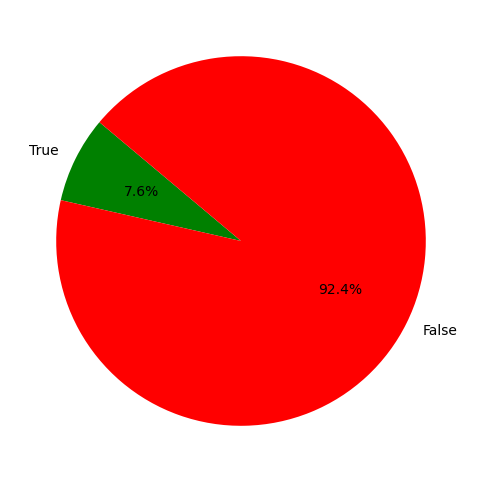

In [ ]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code,'2023-10-12','2023-10-13')
        
        if len(df) < 2:
            result[code] = False
        else:
            today_close = df['Close'].iloc[-1]
            yesterday_close = df['Close'].iloc[-2]
            
            if today_close >= yesterday_close * 1.05 :
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(result)
result_TF = list(result_TF.values())

# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count

# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# 그래프 표시
plt.show()